In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import fetch_openml 
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.svm import SVC 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import time
from IPython.display import clear_output

# Importing and Splitting Data

In [2]:
data = fetch_openml('Kuzushiji-MNIST')

In [3]:
X, t = data.data.to_numpy(), data.target.to_numpy()
X = X/255. # accomplishes the scaling
X = X.reshape((70000,28,28))
t = t.astype(np.uint8)

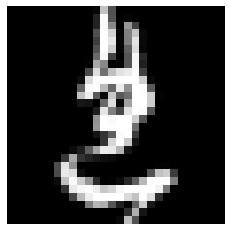

In [4]:
plt.imshow(X[34566], cmap='gray')
plt.axis('off');

In [5]:
X_train, X_test, t_train, t_test = X[:60000], X[60000:], t[:60000], t[60000:]
X_train, X_val, t_train, t_val = train_test_split(X_train, t_train, 
                                                  test_size = 0.20,
                                                  stratify = t_train)

# Constructing and Tuning SAE

In [15]:
scores = np.zeros((6, 3, 2))

for b_idx, bottleneck in np.ndenumerate([25, 50, 75, 100, 125, 150]):
    for a_idx, activation in np.ndenumerate(['linear', 'relu', 'selu']):
        encoder = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28,28]),
        keras.layers.Dense(600, use_bias=False, activation=activation),
        keras.layers.Dense(200, use_bias=False, activation=activation),
        keras.layers.Dense(bottleneck, use_bias=False, activation=activation)
        ])

        decoder = keras.models.Sequential([
            keras.layers.Dense(200, use_bias=False, activation=activation),
            keras.layers.Dense(600, use_bias=False, activation=activation),
            keras.layers.Dense(28*28, use_bias=False, activation=activation),
            keras.layers.Reshape([28, 28])
        ])

        autoencoder = keras.models.Sequential([encoder, decoder])

        autoencoder.compile(loss=keras.losses.mean_squared_error, 
                        optimizer=keras.optimizers.SGD(learning_rate=0.1))

        history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=1024,
                                  validation_data=(X_val, X_val))

        clear_output()

        scores[b_idx, a_idx, :] = history.history['loss'][-1], history.history['val_loss'][-1]

In [22]:
scores

array([[[0.06298898, 0.06268311],
        [0.10070255, 0.10016644],
        [0.07301266, 0.07269272]],

       [[0.05593485, 0.05568397],
        [0.09773645, 0.09717999],
        [0.06489948, 0.06463417]],

       [[0.05220839, 0.05192315],
        [0.09154613, 0.09109823],
        [0.06329273, 0.06303101]],

       [[0.05046506, 0.0502525 ],
        [0.09233329, 0.09173851],
        [0.06335305, 0.06311584]],

       [[0.04964226, 0.04940407],
        [0.09126224, 0.09076972],
        [0.06311855, 0.06286634]],

       [[0.04869576, 0.04845455],
        [0.09385329, 0.09335617],
        [0.06187794, 0.06159993]]])

In [6]:
bottleneck = 150

In [23]:
encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(600, use_bias=False),
    keras.layers.Dense(200, use_bias=False),
    keras.layers.Dense(bottleneck, use_bias=False)
])

decoder = keras.models.Sequential([
    keras.layers.Dense(200, use_bias=False),
    keras.layers.Dense(600, use_bias=False),
    keras.layers.Dense(28*28, use_bias=False),
    keras.layers.Reshape([28, 28])
])

autoencoder = keras.models.Sequential([encoder, decoder])

In [24]:
autoencoder.compile(loss=keras.losses.mean_squared_error, 
                    optimizer=keras.optimizers.SGD(learning_rate=0.1))

In [25]:
history = autoencoder.fit(X_train, X_train, epochs=200, batch_size=2048,
                         validation_data=(X_val, X_val))

Epoch 1/200
24/24 [==============================] - 1s 26ms/step - loss: 0.2197 - val_loss: 0.1984
Epoch 2/200
24/24 [==============================] - 0s 19ms/step - loss: 0.1895 - val_loss: 0.1793
Epoch 3/200
24/24 [==============================] - 0s 19ms/step - loss: 0.1721 - val_loss: 0.1633
Epoch 4/200
24/24 [==============================] - 0s 19ms/step - loss: 0.1569 - val_loss: 0.1492
Epoch 5/200
24/24 [==============================] - 0s 19ms/step - loss: 0.1441 - val_loss: 0.1380
Epoch 6/200
24/24 [==============================] - 0s 19ms/step - loss: 0.1343 - val_loss: 0.1299
Epoch 7/200
24/24 [==============================] - 0s 19ms/step - loss: 0.1273 - val_loss: 0.1240
Epoch 8/200
24/24 [==============================] - 0s 19ms/step - loss: 0.1222 - val_loss: 0.1198
Epoch 9/200
24/24 [==============================] - 0s 19ms/step - loss: 0.1185 - val_loss: 0.1166
Epoch 10/200
24/24 [==============================] - 0s 19ms/step - loss: 0.1156 - val_loss: 0.1140

In [26]:
class_names = np.array([0,1,2,3,4,5,6,7,8,9])

In [27]:
codings = encoder.predict(X_train) 

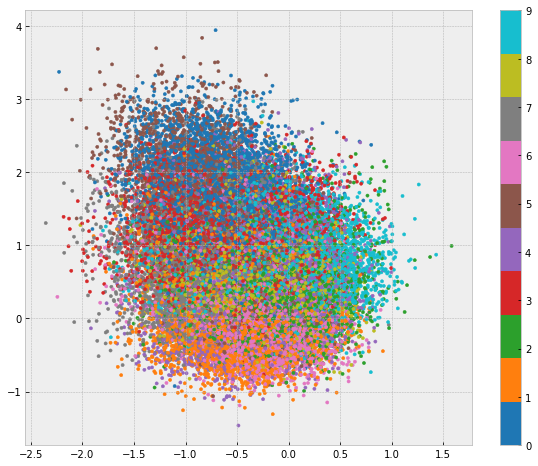

In [28]:
# visualize encoded data
plt.figure(figsize=(10,8)) 
plt.scatter(codings[:,20], codings[:,45], c=t_train, s=10, cmap='tab10')
plt.rcParams['axes.grid'] = False
cbar = plt.colorbar(ticks=range(10))
cbar.ax.set_yticklabels(class_names);

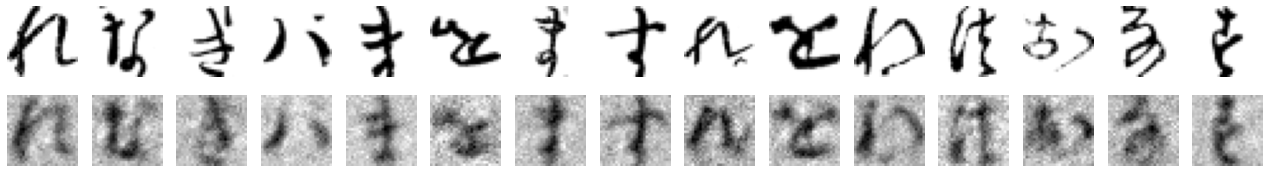

In [29]:
# visualize images reconstructed from encodings
def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')

def show_reconstructions(model, n_images=15):
    reconstructions = model.predict(X_val[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(X_val[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

show_reconstructions(autoencoder)

In [30]:
# encoding data
codings_train = encoder.predict(X_train)
codings_val = encoder.predict(X_val)
codings_test = encoder.predict(X_test)

# Constructing and Tuning Support-Vector Machine

In [32]:
svm = SVC()

In [33]:
# grid search for optimal SVM hyperparameters
param_grid = {'C': [1,10,50,100],
              'kernel': ['linear', 'rbf']}

classifier = GridSearchCV(svm,
                          param_grid=param_grid,
                          cv=KFold(3,shuffle=True),
                          scoring='accuracy',
                          refit=True,
                          verbose=3)

In [ ]:
classifier.fit(codings_train, t_train)
classifier.best_params_

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END ................C=1, kernel=linear;, score=0.838 total time= 1.1min
[CV 2/3] END ................C=1, kernel=linear;, score=0.842 total time= 1.1min
[CV 3/3] END ................C=1, kernel=linear;, score=0.837 total time= 1.1min
[CV 1/3] END ...................C=1, kernel=rbf;, score=0.933 total time= 1.2min
[CV 2/3] END ...................C=1, kernel=rbf;, score=0.934 total time= 1.2min
[CV 3/3] END ...................C=1, kernel=rbf;, score=0.933 total time= 1.2min
[CV 1/3] END ...............C=10, kernel=linear;, score=0.836 total time= 4.4min
[CV 2/3] END ...............C=10, kernel=linear;, score=0.838 total time= 4.4min
[CV 3/3] END ...............C=10, kernel=linear;, score=0.833 total time= 4.4min
[CV 1/3] END ..................C=10, kernel=rbf;, score=0.953 total time=  57.1s
[CV 2/3] END ..................C=10, kernel=rbf;, score=0.954 total time=  57.6s
[CV 3/3] END ..................C=10, kernel=rbf;,

In [ ]:
# inferencing on encoded data
y_train = classifier.predict(codings_train)
y_val = classifier.predict(codings_val)
y_test = classifier.predict(codings_test)

In [ ]:
# performance check on rough draft
accuracy_score(t_train, y_train), accuracy_score(t_val, y_val), accuracy_score(t_test, y_test)